In [84]:
import surprise
import json
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import re
from surprise import accuracy
from surprise.model_selection import GridSearchCV

In [2]:
with open('All_Beauty_5.json', 'r') as f:
    data = json.load(f)

In [3]:
meta = []
with open('meta_All_Beauty.json', 'r') as f:
    for l in f:
        meta.append(json.loads(l.strip()))

In [4]:
df = pd.DataFrame(data)
df_meta = pd.DataFrame.from_dict(meta)

In [40]:
df_all = df.merge(df_meta, left_on='asin', right_on='asin', how='left')

In [6]:
df_all.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,...,feature,rank,also_view,details,main_cat,similar_item,date,price,imageURL,imageURLHighRes
0,5.0,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,...,[],"65,003 in Beauty & Personal Care (","[B01I9TIY1U, B07L1PZCS7, B01N12C89Y, B01I9TINT...",{' Product Dimensions: ': '3 x 4 x 5 ...,All Beauty,,,,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
1,5.0,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,...,[],"65,003 in Beauty & Personal Care (","[B01I9TIY1U, B07L1PZCS7, B01N12C89Y, B01I9TINT...",{' Product Dimensions: ': '3 x 4 x 5 ...,All Beauty,,,,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
2,5.0,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,1384387200,...,[],"65,003 in Beauty & Personal Care (","[B01I9TIY1U, B07L1PZCS7, B01N12C89Y, B01I9TINT...",{' Product Dimensions: ': '3 x 4 x 5 ...,All Beauty,,,,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
3,5.0,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,1384387200,...,[],"65,003 in Beauty & Personal Care (","[B01I9TIY1U, B07L1PZCS7, B01N12C89Y, B01I9TINT...",{' Product Dimensions: ': '3 x 4 x 5 ...,All Beauty,,,,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,1.0,True,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Adam,I bought this to smell nice after I shave. Wh...,Smells awful,1376784000,...,[],"65,003 in Beauty & Personal Care (","[B01I9TIY1U, B07L1PZCS7, B01N12C89Y, B01I9TINT...",{' Product Dimensions: ': '3 x 4 x 5 ...,All Beauty,,,,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [7]:
df_all.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image', 'category', 'tech1', 'description', 'fit', 'title', 'also_buy',
       'tech2', 'brand', 'feature', 'rank', 'also_view', 'details', 'main_cat',
       'similar_item', 'date', 'price', 'imageURL', 'imageURLHighRes'],
      dtype='object')

# EDA

In [9]:
# распределение рейтингов от 1 до 5, в основном все ставят максимальную оценку
df_all.describe()

,overall,unixReviewTime
count,5767.000000,5.767000e+03
mean,4.770591,1.442242e+09
std,0.751169,5.440093e+07
min,1.000000,1.095725e+09
25%,5.000000,1.407586e+09
50%,5.000000,1.447114e+09
75%,5.000000,1.481674e+09
max,5.000000,1.534982e+09


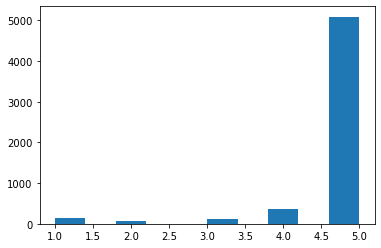

In [10]:
plt.hist(df_all['overall']);

In [11]:
df_user_buys = df_all.groupby('reviewerID')['asin'].count().reset_index()

In [12]:
# число уникальных пользователей
len(df_user_buys)

991

In [13]:
# так как все пользователи совершили минимум 4 покупки, их всех можно считать активными
df_user_buys.describe()

,asin
count,991.000000
mean,5.819374
std,0.908250
min,5.000000
25%,5.000000
50%,6.000000
75%,6.000000
max,12.000000


In [14]:
df_item_buys = df_all.groupby('asin')['reviewerID'].count().reset_index()

In [15]:
# число уникальных товаров
len(df_item_buys)

85

In [16]:
df_item_buys.describe()

,reviewerID
count,85.000000
mean,67.847059
std,246.684757
min,1.000000
25%,3.000000
50%,6.000000
75%,13.000000
max,1794.000000


In [33]:
df_item_buys[df_item_buys['reviewerID']>13]

,asin,reviewerID
1,B00006L9LC,978
5,B0009RF9DW,392
6,B000FI4S1E,392
7,B000FOI48G,15
9,B000GLRREU,15
11,B000NKJIXM,15
13,B000URXP6E,858
23,B0010ZBORW,98
29,B0012Y0ZG2,1794
30,B0013NB7DW,40


In [150]:
df_user_ratings = df_all.groupby('reviewerID')['overall'].mean().reset_index()

In [151]:
df_user_ratings.describe()

,overall
count,991.000000
mean,4.778616
std,0.697025
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


In [160]:
# пользователи с низкими оценками
df_user_ratings[df_user_ratings['overall']<3].head(10)

,reviewerID,overall
52,A18HENNBJ25817,1.0
77,A1BAZK7LSPBPEJ,2.0
96,A1DFI14L1LBOPJ,2.0
126,A1J7I5095JBHH,1.0
223,A1WGC9NCI09T3D,1.0
230,A1WWZ1NKXLFYNG,2.0
248,A1ZM06J2A5XGHY,1.0
283,A24W4W9E62FZP2,2.0
291,A25DAQQXXA356R,2.0
312,A27PPA3O7PX0OH,1.0


In [35]:
len(df_all[~df_all['asin'].isin(df_item_buys[df_item_buys['reviewerID']>300]['asin'])])

864

In [41]:
# удаляем товары со слишком большим количеством покупок для сравнения со всем датасетом
df_mini = df_all[~df_all['asin'].isin(df_item_buys[df_item_buys['reviewerID']>300]['asin'])].drop_duplicates('asin').reset_index().drop('index', axis=1)

In [42]:
reader = surprise.Reader(line_format='user item rating', rating_scale=(1, 5))

# Train-test splitting

In [53]:
# в тестовый массив заносятся более поздние покупки с учетом ration, в тренировочный - более ранние
def train_test_split(X, ratio=0.2, user_col='reviewerID', item_col='asin',
                     rating_col='overall', time_col='unixReviewTime'):

    X.sort_values(by=[time_col], inplace=True)

    userIds = X[user_col].unique()
    X_train_data = []
    X_test_data = []

    for userId in userIds:
        curUser = X[X[user_col] == userId]
        idx = int(curUser.shape[0] * (1 - ratio))
        X_train_data.append(curUser.iloc[:idx, :].values)
        X_test_data.append(curUser.iloc[idx:, :].values)

    X_train = pd.DataFrame(np.vstack(X_train_data), columns=[user_col, item_col, rating_col, time_col])
    X_test = pd.DataFrame(np.vstack(X_test_data), columns=[user_col, item_col, rating_col, time_col])

    return X_train, X_test

In [59]:
X_train, X_test = train_test_split(df_all[['reviewerID', 'asin', 'overall', 'unixReviewTime']])
X_train_mini, X_test_mini = train_test_split(df_mini[['reviewerID', 'asin', 'overall', 'unixReviewTime']])

C:\Users\koren\AppData\Local\Temp\ipykernel_9284\4008855954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.sort_values(by=[time_col], inplace=True)
C:\Users\koren\AppData\Local\Temp\ipykernel_9284\4008855954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.sort_values(by=[time_col], inplace=True)


In [56]:
X_train.head(10)

,reviewerID,asin,overall,unixReviewTime
0,A281NPSIMI1C2R,B0002JHI1I,5.0,1095724800
1,A281NPSIMI1C2R,B0002JHI1I,5.0,1095724800
2,A281NPSIMI1C2R,B0002JHI1I,5.0,1119916800
3,A281NPSIMI1C2R,B0002JHI1I,5.0,1119916800
4,A281NPSIMI1C2R,B0006O10P4,5.0,1506038400
5,AIIR8E34EDKCQ,B000FI4S1E,5.0,1148083200
6,AIIR8E34EDKCQ,B0009RF9DW,5.0,1148083200
7,AIIR8E34EDKCQ,B000PKKAGO,4.0,1197936000
8,AIIR8E34EDKCQ,B0009RF9DW,5.0,1231286400
9,AIIR8E34EDKCQ,B000FI4S1E,5.0,1231286400


In [57]:
X_test.head(10)

,reviewerID,asin,overall,unixReviewTime
0,A281NPSIMI1C2R,B00120VWTK,5.0,1508284800
1,A281NPSIMI1C2R,B00120VWTK,5.0,1508284800
2,AIIR8E34EDKCQ,B00021DJ32,5.0,1418515200
3,AIIR8E34EDKCQ,B00021DJ32,5.0,1418515200
4,A25C2M3QF9G7OQ,B00W259T7G,5.0,1503705600
5,A25C2M3QF9G7OQ,B002GP80EU,5.0,1504310400
6,A1FWFCJU2G7TRA,B000VUXCGI,5.0,1424908800
7,A3SMR4HRFJARSC,B00W259T7G,2.0,1505692800
8,A2JCJJNY43QQIV,B00NT0AR7E,5.0,1422403200
9,A2JCJJNY43QQIV,B008YQM4A6,5.0,1445644800


In [58]:
df_train = surprise.Dataset.load_from_df(X_train[['reviewerID', 'asin', 'overall']], reader)
df_test = surprise.Dataset.load_from_df(X_test[['reviewerID', 'asin', 'overall']], reader)

In [122]:
df_train_test = surprise.Dataset.load_from_df(pd.concat([X_train[['reviewerID', 'asin', 'overall']], X_test[['reviewerID', 'asin', 'overall']]], axis=0), reader)

In [60]:
df_train_mini = surprise.Dataset.load_from_df(X_train_mini[['reviewerID', 'asin', 'overall']], reader)
df_test_mini = surprise.Dataset.load_from_df(X_test_mini[['reviewerID', 'asin', 'overall']], reader)

# Baseline

In [75]:
# рейтинг предсказывается на основе трех чисел - среднего всех рейтингов, смещения по пользователю, смещения по товару
df_train_s = df_train.build_full_trainset()
df_test_s = [df_test.df.loc[i].to_list() for i in range(len(df_test.df))]

In [76]:
df_train_mini_s = df_train_mini.build_full_trainset()
df_test_mini_s = [df_test_mini.df.loc[i].to_list() for i in range(len(df_test_mini.df))]

In [77]:
bl = surprise.BaselineOnly()

In [78]:
bl.fit(df_train_s)
predictions = bl.test(df_test_s)
print('RMSE for full dataset in Baseline: ', accuracy.rmse(predictions))

Estimating biases using als...
RMSE: 0.6352
RMSE for full dataset in Baseline:  0.6352141588926041


In [79]:
bl.fit(df_train_mini_s)
predictions = bl.test(df_test_mini_s)
print('RMSE for mini dataset in Baseline: ', accuracy.rmse(predictions))

Estimating biases using als...
RMSE: 1.1306
RMSE for mini dataset in Baseline:  1.1306366762869116


# SVD++

In [98]:
# идея в восстановлении исходной матрицы, и, соотвественно, отсутствующих рейтингов благодаря разложению исходной матрицы на проивзедение двух матриц.
# в SVD++ добавляется implicit матрица путем усреднения эмбеддингов по товарам, которые пользователь просмотрел
param_grid = {"n_factors": [50, 80, 100], "n_epochs": [5, 10, 20], "lr_all": [0.002, 0.005], "reg_all": [0.4, 0.6]}
gs = GridSearchCV(surprise.SVDpp, param_grid, measures=["rmse"], cv=3)

In [99]:
gs.fit(df_train)
print(gs.best_score['rmse'], gs.best_params['rmse'])

0.6029659884202484 {'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.4}


In [100]:
svdpp = gs.best_estimator['rmse']

In [101]:
svdpp.fit(df_train_s)
predictions = svdpp.test(df_test_s)
print('RMSE for full dataset in SVD++: ', accuracy.rmse(predictions))

RMSE: 0.6226
RMSE for full dataset in SVD++:  0.6226059386335314


In [102]:
svdpp.fit(df_train_mini_s)
predictions = svdpp.test(df_test_mini_s)
print('RMSE for mini dataset in SVD++: ', accuracy.rmse(predictions))

RMSE: 1.1302
RMSE for mini dataset in SVD++:  1.1301903957226969


# KNN

In [103]:
# для user-based - для каждого пользователя ищуется похожие на него, и вычисляются пропуски как среднее взвешенное на основе того, какие рейтинги поставили близкие пользователи. То же самое для item-based.
param_grid = {'k': [5, 10, 20, 40], 'min_k': [2,], 'sim_options': {'name': ['cosine'], 'user_based': [True, False]}}
gs = GridSearchCV(surprise.KNNBaseline, param_grid, measures=["rmse"], cv=3)

In [104]:
gs.fit(df_train)
print(gs.best_score['rmse'], gs.best_params['rmse'])

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Comput

In [105]:
knn = gs.best_estimator['rmse']

In [106]:
knn.fit(df_train_s)
predictions = svdpp.test(df_test_s)
print('RMSE for full dataset in KNN: ', accuracy.rmse(predictions))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9023
RMSE for full dataset in KNN:  0.9022775980720071


In [107]:
knn.fit(df_train_mini_s)
predictions = svdpp.test(df_test_mini_s)
print('RMSE for mini dataset in KNN: ', accuracy.rmse(predictions))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1302
RMSE for mini dataset in KNN:  1.1301903957226969


# SlopeOne

In [108]:
# отсутствующие рейтинги рассчитываются на основе вычисления средней разницы между тем, что поставил конкретный пользователь и другими пользователями, и добавления этой разницы
so1 = surprise.SlopeOne()

In [109]:
so1.fit(df_train_s)
predictions = so1.test(df_test_s)
print('RMSE for full dataset in SlopeOne: ', accuracy.rmse(predictions))

RMSE: 0.2953
RMSE for full dataset in SlopeOne:  0.29528311220085196


In [110]:
so1.fit(df_train_mini_s)
predictions = so1.test(df_test_mini_s)
print('RMSE for mini dataset in SlopeOne: ', accuracy.rmse(predictions))

RMSE: 1.1300
RMSE for mini dataset in SlopeOne:  1.1300070681840406


# CoClustering

In [111]:
# пользователи и товары распределяются на кластеры, и для этих кластеров уже считаются средние, например, могут быть кластеры "вредный пользователь - товар с высокой оценкой"
param_grid = {'n_cltr_u': [3, 6, 10, 20], 'n_cltr_i': [3, 6, 10, 20], 'n_epochs': [30, 50]}
gs = GridSearchCV(surprise.CoClustering, param_grid, measures=["rmse"], cv=3)

In [112]:
gs.fit(df_train)
print(gs.best_score['rmse'], gs.best_params['rmse'])

0.38050316183067806 {'n_cltr_u': 6, 'n_cltr_i': 10, 'n_epochs': 30}


In [113]:
cc = gs.best_estimator['rmse']

In [114]:
cc.fit(df_train_s)
predictions = cc.test(df_test_s)
print('RMSE for full dataset in CoClustering: ', accuracy.rmse(predictions))

RMSE: 0.3231
RMSE for full dataset in CoClustering:  0.323093706923109


In [115]:
cc.fit(df_train_mini_s)
predictions = cc.test(df_test_mini_s)
print('RMSE for mini dataset in CoClustering: ', accuracy.rmse(predictions))

RMSE: 1.1300
RMSE for mini dataset in CoClustering:  1.1300070681840406


# Best recommendations

In [116]:
# лучший алгоритм - SlopeOne на полном датасете
so1 = surprise.SlopeOne()

In [156]:
df_train_all_s = df_train_test.build_full_trainset()

so1.fit(df_train_all_s)

In [124]:
df_train_test_s = df_train_test.build_full_trainset()
df_anti = df_train_test_s.build_anti_testset()

In [125]:
len(df_anti)

80143

In [149]:
df_anti[:10]

[('A281NPSIMI1C2R', 'B000FI4S1E', 4.77059129530085),
 ('A281NPSIMI1C2R', 'B0009RF9DW', 4.77059129530085),
 ('A281NPSIMI1C2R', 'B000PKKAGO', 4.77059129530085),
 ('A281NPSIMI1C2R', 'B006WYJM8Y', 4.77059129530085),
 ('A281NPSIMI1C2R', 'B000FOI48G', 4.77059129530085),
 ('A281NPSIMI1C2R', 'B000GLRREU', 4.77059129530085),
 ('A281NPSIMI1C2R', 'B001F51RAG', 4.77059129530085),
 ('A281NPSIMI1C2R', 'B000NKJIXM', 4.77059129530085),
 ('A281NPSIMI1C2R', 'B000LIBUBY', 4.77059129530085),
 ('A281NPSIMI1C2R', 'B000VUXCGI', 4.77059129530085)]

In [129]:
products = {k:v for (k,v) in zip(df_all['asin'], df_all['title'])}

In [127]:
def get_top_n(predictions, n=100):

    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [157]:
def get_recommendations(user_id, n=10):
    global products, df_anti
    
    products_bought = set(df_all[df_all['reviewerID'] == user_id]['asin'])
    products_bought_1 = [products[i] for i in products_bought]
    
    print(user_id)
    print('Куплено\n')
    for pr in products_bought_1:
        print(pr)
    
    testset_1 = (el for el in df_anti if el[0] == user_id)
    predictions = so1.test(testset_1)
    
    products_rec = get_top_n(predictions, n=n)[user_id]
    products_rec = [p for p in products_rec if p[0] not in products_bought]
    
    products_rec_1 = [(products[p[0]], p[1]) for p in products_rec]
    print('\n\nРекомендации\n')
    for pr in products_rec_1:
        print(pr)
    
    return products_rec

In [158]:
rec = get_recommendations('A281NPSIMI1C2R')

A281NPSIMI1C2R
Куплено

Avalon Organics Wrinkle Therapy CoQ10 Cleansing Milk, 8.50 oz
Avalon Organics Vitamin C Renewal Creme, 2 oz
ZUM Zum Bar Anise Lavender, 3 Ounce


Рекомендации

('Fruits &amp; Passion Blue Refreshing Shower Gel - 6.7 fl. oz.', 5)
('Yardley By Yardley Of London Unisexs Lay It On Thick Hand &amp; Foot Cream 5.3 Oz', 5)
("Philips Norelco arcitec 1090 Men's Shaving System", 5)
('NARS Blush, Gaiety', 5)
('Waterpik Ultra Water Flosser', 5)
('Waterpik Ultra Water Flosser', 5)
('Oral-B Glide Pro-Health Dental Floss, Original Floss, 50m, Pack of 6', 5)
('Crest Pro-health Multi-Protection Rinse, Cool Wintergreen, 33.8 Fluid Ounce', 5)
('Fresh Eau de Parfum, Sugar Lemon, 3.4 oz', 5)
("Maggie's Functional Organics Raspberry Navy Forest 9-11", 5)


In [153]:
# рекомендации для пользователя с низкими оценками
rec = get_recommendations('A1DFI14L1LBOPJ')

A1DFI14L1LBOPJ
Куплено

Citre Shine Moisture Burst Shampoo - 16 fl oz
Bonne Bell Smackers Bath and Body Starburst Collection
Bath &amp; Body Works Ile De Tahiti Moana Coconut Vanille Moana Body Wash with Tamanoi 8.5 oz
Avalon Grapefruit and Geranium Smoothing Shampoo, 11 Ounce


Рекомендации

('Bali Secrets Natural Deodorant - Organic &amp; Vegan - For Women &amp; Men - All Day Fresh - Strong &amp; Reliable Protection - 2.5 fl.oz/75ml [Scent: Sandalwood]', 5)
('Avalon Organics Wrinkle Therapy CoQ10 Cleansing Milk, 8.50 oz', 2.0)
('ZUM Zum Bar Anise Lavender, 3 Ounce', 2.0)
("Philips Norelco arcitec 1090 Men's Shaving System", 2.0)
('NARS Blush, Gaiety', 2.0)
('Waterpik Ultra Water Flosser', 2.0)
('Waterpik Ultra Water Flosser', 2.0)
('Oral-B Glide Pro-Health Dental Floss, Original Floss, 50m, Pack of 6', 2.0)
('Crest Pro-health Multi-Protection Rinse, Cool Wintergreen, 33.8 Fluid Ounce', 2.0)
('Fresh Eau de Parfum, Sugar Lemon, 3.4 oz', 2.0)


In [161]:
# рекомендации для пользователя с низкими оценками
rec = get_recommendations('A25DAQQXXA356R')

A25DAQQXXA356R
Куплено

Fruits &amp; Passion Blue Refreshing Shower Gel - 6.7 fl. oz.
Bonne Bell Smackers Bath and Body Starburst Collection
Yardley By Yardley Of London Unisexs Lay It On Thick Hand &amp; Foot Cream 5.3 Oz
Bath &amp; Body Works Ile De Tahiti Moana Coconut Vanille Moana Body Wash with Tamanoi 8.5 oz


Рекомендации

('Bali Secrets Natural Deodorant - Organic &amp; Vegan - For Women &amp; Men - All Day Fresh - Strong &amp; Reliable Protection - 2.5 fl.oz/75ml [Scent: Sandalwood]', 5)
('Avalon Grapefruit and Geranium Smoothing Shampoo, 11 Ounce', 2.401636162880182)
('Avalon Organics Wrinkle Therapy CoQ10 Cleansing Milk, 8.50 oz', 2.0)
('ZUM Zum Bar Anise Lavender, 3 Ounce', 2.0)
('NARS Blush, Gaiety', 2.0)
('Waterpik Ultra Water Flosser', 2.0)
('Waterpik Ultra Water Flosser', 2.0)
('Oral-B Glide Pro-Health Dental Floss, Original Floss, 50m, Pack of 6', 2.0)
('Crest Pro-health Multi-Protection Rinse, Cool Wintergreen, 33.8 Fluid Ounce', 2.0)
('Fresh Eau de Parfum, Sugar Lem

# Выводы

1. Желательно добавить текстовые эмбеддинги для товаров, а также для прошлых покупок пользователей
2. В будущем можно учитывать количество покупок определенных товаров и их категорию
3. Для больших датаестов нужно учитывать проверенность отзыва и соотнесение текстового описания с проставленной оценкой